In [4]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import numpy as np
from numpy.fft import rfft2, irfft2, ifftshift
from scipy.signal import fftconvolve
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter
from numba import njit
import cv2
from scipy.optimize import curve_fit

In [6]:
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

def estimate_sigma(noise_image, weight, maxlag):
    local_covariance = covariance_fft2d(noise_image, maxlag)
    variance = weighted_variance_lag(weight, local_covariance, maxlag)
    return np.sqrt(variance)

def covariance_fft2d(image, maxlag):
    """
    Compute 2D covariance by FFT of background-subtracted residual.
    - image: 2D array (float)
    - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
    Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
    """
    img = image.astype(float)
    h, w = img.shape
    img -= np.mean(img)

    ac = fftconvolve(img, img[::-1, ::-1], mode="same")

    ac_norm = ac / (h * w)

    cy, cx = h//2, w//2
    window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
    return window


@njit
def weighted_variance_lag(s, C_local, max_lag):
    H, W = s.shape
    V = 0.0
    for dy in range(-max_lag, max_lag + 1):
        for dx in range(-max_lag, max_lag + 1):
            y0 = max(0, -dy)
            y1 = min(H, H - dy)
            x0 = max(0, -dx)
            x1 = min(W, W - dx)
            s1 = s[y0:y1, x0:x1]
            s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
            V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
    return V

# @njit(fastmath=True)
def gaussian_1d(n, center, sigma):
    x = np.arange(n, dtype=float)
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

def gaussian_weight(height, width, xc=0, yc=0, a=1, b=1):
    gx = gaussian_1d(width,  xc, a)
    gy = gaussian_1d(height, yc, b)

    weight = gy[:, None] * gx[None, :]
    weight /= weight.sum()
    return weight

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"])
    F = psf_cache["H_conj"]*W / psf_cache["denom"]
    result = irfft2(F, psf_cache["pad_shape"])

    h, w = psf_cache["image_shape"]
    return result[:h, :w]

def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    # weight_rescale /= np.sum(weight_rescale)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)
    measured_F = np.full(len(centers), np.nan, dtype=np.float32)
    measured_F[valid] = map_coordinates(flux_map, [ys[valid], xs[valid]], order=1)

    return measured_F, weight_rescale


def gaussian_2d(xy, amplitude, sigma, x0, y0):
    x, y = xy
    r_2 = (x - x0)**2 + (y - y0)**2
    g = amplitude * np.exp(
        -r_2/(2*sigma**2)
    )
    return g.ravel()

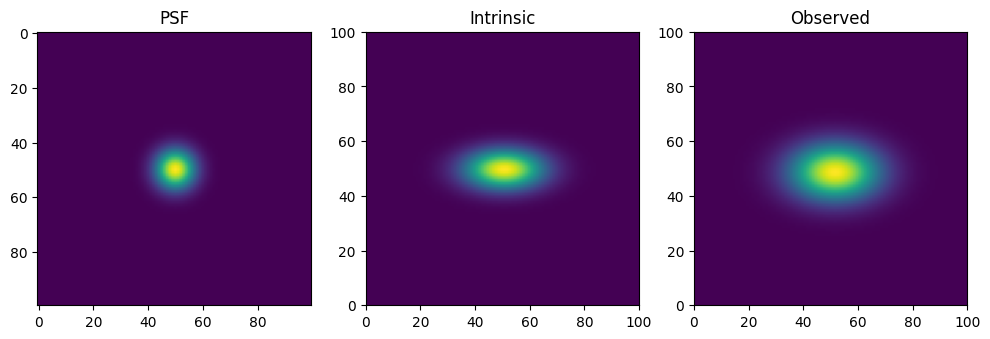

: 

In [ ]:
width = 100
height = 100
source_x_sigma = 10
source_y_sigma = 5
# Create PSF and Galaxy images
psf_sigma = 5
image_psf = gaussian_weight(height, width, height / 2, width / 2, psf_sigma, psf_sigma)
image_intrinsic = gaussian_weight(height, width, height / 2, width / 2, source_x_sigma, source_y_sigma) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf)
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [ ]:
def elliptical_gaussian(coords, A, x0, y0, sigma_x, sigma_y, theta):
    """
    2D elliptical Gaussian with rotation.
    
    coords : tuple of (x, y) flattened
    """
    x, y = coords
    cos_t = np.cos(theta)
    sin_t = np.sin(theta)
    
    x_shift = x - x0
    y_shift = y - y0
    
    x_rot = cos_t * x_shift + sin_t * y_shift
    y_rot = -sin_t * x_shift + cos_t * y_shift
    
    g = A * np.exp(-0.5 * ((x_rot/sigma_x)**2 + (y_rot/sigma_y)**2))
    return g.ravel()

def deconv_gaussian_rms(image):
    """
    Fit an elliptical Gaussian to the deconvolved image
    and compute RMS error.
    
    Parameters
    ----------
    image : 2D array
        Deconvolved image
    
    Returns
    -------
    rms_error : float
        Root-mean-square difference relative to max of image
    fit_params : dict
        Fitted Gaussian parameters: A, x0, y0, sigma_x, sigma_y, theta
    """
    ny, nx = image.shape
    y, x = np.indices(image.shape)
    
    # Initial guess
    A0 = image.max()
    x0 = nx / 2
    y0 = ny / 2
    sigma_x = nx / 4
    sigma_y = ny / 4
    theta = 0.0
    p0 = (A0, x0, y0, sigma_x, sigma_y, theta)
    
    try:
        popt, _ = curve_fit(
            elliptical_gaussian,
            (x.ravel(), y.ravel()),
            image.ravel(),
            p0=p0,
            bounds=(
                [0, 0, 0, 0, 0, -np.pi/2],
                [np.inf, nx, ny, nx, ny, np.pi/2]
            )
        )
    except RuntimeError:
        # fit failed
        return np.inf, None
    
    # Reconstruct Gaussian
    fit_image = elliptical_gaussian((x, y), *popt).reshape(image.shape)
    
    # RMS error relative to max
    rms_error = np.sqrt(np.mean((image - fit_image)**2)) / image.max()
    
    fit_params = {
        "A": popt[0],
        "x0": popt[1],
        "y0": popt[2],
        "sigma_x": popt[3],
        "sigma_y": popt[4],
        "theta": popt[5]
    }
    
    return rms_error, fit_params


: 

The aperture flux measured using the intrinsic image and weight function : 1.317357
The aperture flux using the observed image and rescaled weight function : 1.317357


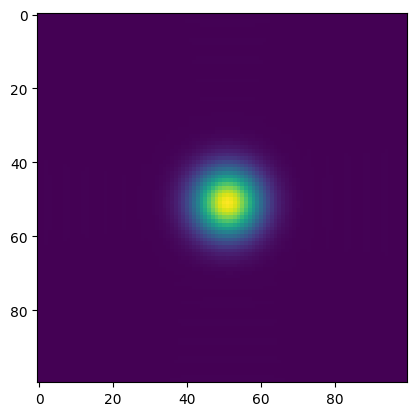

RMS error: 0.0006147726740352601
Deconvolution is very Gaussian-like


: 

In [ ]:
# Define weight function
weight_size = 8
weight = gaussian_weight(height, width, height / 2, width / 2, weight_size, weight_size)
k_c = min(1/weight_size, np.pi/width, np.pi/2)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')
noise = np.random.normal(0, .1, size=image.shape)*0
cache = prepare_wiener_psf(image_psf, [width, height], K=1e-16)
# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, weight_new = calculate_gaap_flux(image + noise, cache, weight, [(height / 2, width / 2)])

print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')
plt.imshow(weight_new)
plt.show()
rms, params = deconv_gaussian_rms(weight_new)
print("RMS error:", rms)

if rms < 0.01:
    print("Deconvolution is very Gaussian-like")
else:
    print("Significant deviation from Gaussian")

The aperture flux measured using the intrinsic image and weight function : 1.747375
The aperture flux using the observed image and rescaled weight function : 1.748389


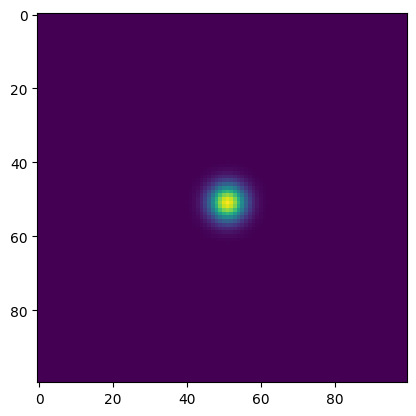

: 

In [ ]:
# Define weight function
weight_size = 6
weight = gaussian_weight(height, width, height / 2, width / 2, weight_size, weight_size)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')
noise = np.random.normal(0, .1, size=image.shape)
cache = prepare_wiener_psf(image_psf, [height, width], K=1e-16)
# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, weight_new = calculate_gaap_flux(image + noise, cache, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')
plt.imshow(weight_new)
plt.show()

(101, 101)
(101, 101)
(101, 101)
(101, 101)
(101, 101)
(101, 101)
(101, 101)
(101, 101)
(101, 101)
(101, 101)


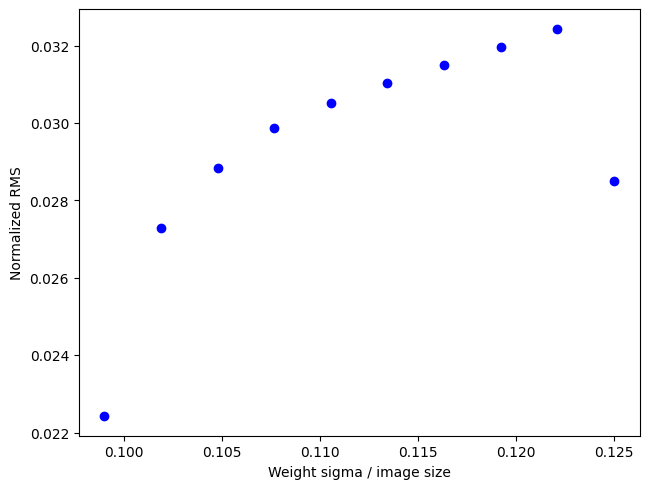

: 

In [ ]:
psf_sigma = 10
for size in np.logspace(np.log10(psf_sigma*10+2), np.log10(200), 1):
    # size = 100
    size = int(size)
    image_psf = gaussian_weight(size, size, size / 2, size / 2, psf_sigma, psf_sigma)
    cache = prepare_wiener_psf(image_psf, [size, size], K=1e-16)
    weight_sizes = np.linspace(psf_sigma, size/8, 10)
    rms_values = np.zeros_like(weight_sizes)
    for weight_size in weight_sizes:
        weight = gaussian_weight(size, size, size / 2, size / 2, weight_size, weight_size)
        weight_new = wiener_deconvolution_fast(weight, cache)
        print(weight_new.shape)
        rms, params = deconv_gaussian_rms(weight_new)
        rms_values[weight_sizes == weight_size] = rms
    plt.scatter(weight_sizes/size, rms_values, color='blue')
# plt.axvline(x=psf_sigma/size, c='red')
plt.tight_layout()
plt.xlabel('Weight sigma / image size')
plt.ylabel('Normalized RMS')
plt.savefig('/home/deklerk/GAAP/results/figures/simulation/deconvolution_stability.pdf')
plt.show()


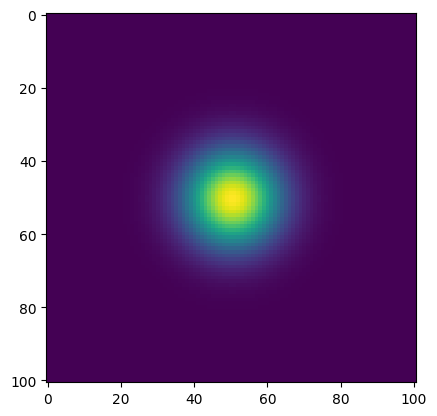

: 

In [ ]:
plt.imshow(gaussian_weight(size, size, size / 2, size / 2, size*0.09, size*0.09))

In [ ]:
from scipy.ndimage import spline_filter

def weights(sigmas, height, width):
    y0, x0 = height / 2, width / 2

    y, x = np.mgrid[:height, :width]
    r2 = (x - x0)**2 + (y - y0)**2
    weights = np.exp(
    -r2[None, :, :] / (2 * sigmas[:, None, None]**2)
    )
    return weights

def prepare_wiener_psf(psf, image_shape, K=0.0, dtype=np.float64):
    """
    Precompute PSF FFT terms for Wiener deconvolution.
    """

    psf = psf[::-1, ::-1].astype(dtype, copy=False)

    pad_shape = (
        image_shape[0] + psf.shape[0] - 1,
        image_shape[1] + psf.shape[1] - 1,
    )

    psf_padded = np.zeros(pad_shape, dtype=dtype)
    y0 = pad_shape[0] // 2 - psf.shape[0] // 2
    x0 = pad_shape[1] // 2 - psf.shape[1] // 2
    psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

    H = rfft2(ifftshift(psf_padded))
    H_conj = np.conj(H)
    denom = (H * H_conj) + K

    return {
        "H_conj": H_conj,
        "denom": denom,
        "pad_shape": pad_shape,
        "image_shape": image_shape,
    }

def wiener_deconvolution_fast(weight, psf_cache, dtype=np.float64):
    """
    Fast Wiener deconvolution using cached PSF FFT data.
    """

    weight = weight.astype(dtype, copy=False)
    W = rfft2(weight, psf_cache["pad_shape"], axes=(-2, -1))
    F = psf_cache["H_conj"][None, :, :] * W / psf_cache["denom"][None, :, :]
    result = irfft2(F, psf_cache["pad_shape"], axes=(-2, -1))

    h, w = psf_cache["image_shape"]
    return result[:, :h, :w]

def calculate_gaap_flux(image, psf_cache, weight, centers):
    """
    Placeholder function for flux calculation.
    """
    weight_rescale = wiener_deconvolution_fast(weight, psf_cache)
    # weight_rescale /= np.sum(weight_rescale)
    flux_map = fftconvolve(image, weight_rescale[::-1, ::-1], mode='same')

    centers = np.asarray(centers)
    ys = centers[:, 1]
    xs = centers[:, 0]

    valid = np.isfinite(xs) & np.isfinite(ys)

    flux_map_f = spline_filter(flux_map, order=1)
    measured_F = np.full(len(centers), np.nan)
    measured_F[valid] = map_coordinates(flux_map_f, [ys[valid], xs[valid]], order=1, prefilter=False)

    return measured_F, weight_rescale

: 

: 

In [ ]:
psf_sigma

10

: 

In [ ]:
sigmas = np.linspace(3, 10, 100)

weights_array = weights(sigmas, height, width)


: 

In [ ]:
psf_sigma = 1

: 

[100, 100]


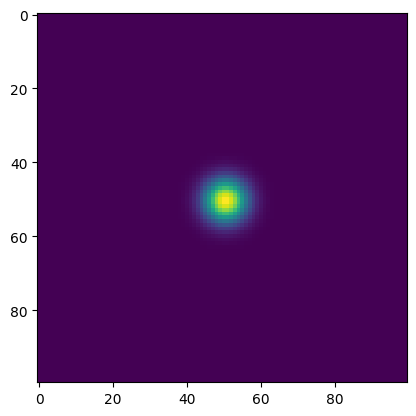

: 

In [ ]:
psf = gaussian_weight(size, size, size / 2, size / 2, psf_sigma, psf_sigma)
cache = prepare_wiener_psf(psf, [width, width], K=1e-16)
print(cache['image_shape'])
weight_new = wiener_deconvolution_fast(weights_array, cache)
plt.imshow(weight_new[16, :, :])
plt.show()

In [66]:
class GAAP_object:
    def __init__(self, image, psf):
        self.image = image
        self.ny, self.nx = image.shape
        self.psf = psf

        self.noise_square = None
        self.flux = None
        self.variance = None

    def find_noise_square(self, image=None, box_size=50):
        """
        Automatically find a square region with low signal (noise-dominated).
        image: 2D array
        box_size: side of the square region (pixels)
        margin: exclude edges
        threshold: how many sigma above the median to consider as "source"
        returns: (y0, x0, y1, x1) slice indices of best noise square
        """
        if image == None:
            image = self.image

        # smooth absolute value to find low-variance zones
        local_mean = uniform_filter(image, size=box_size)
        local_var = uniform_filter(image**2, size=box_size) - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 0))

        # exclude borders
        half = box_size // 2
        local_std[:half, :] = np.inf
        local_std[-half:, :] = np.inf
        local_std[:, :half] = np.inf
        local_std[:, -half:] = np.inf

        # pick minimum std region (least structured)
        cy, cx = np.unravel_index(np.nanargmin(local_std), local_std.shape)

        # ensure square fits inside image
        half = box_size // 2
        y0 = max(0, cy - half)
        x0 = max(0, cx - half)
        y1 = min(self.ny, y0 + box_size)
        x1 = min(self.nx, x0 + box_size)

        self.noise_square = image[y0:y1, x0:x1]

    def padded_cutout_with_center(self, image, cx, cy, size):
        """
        Extract a fixed-size cutout centered on (cy, cx).
        Pads with zeros when the cutout extends beyond the image.

        Returns
        -------
        cutout : (size, size) array
        (cy_c, cx_c) : subpixel center in cutout coordinates
        """

        h, w = image.shape
        half = size // 2

        # Integer anchor
        iy = int(np.floor(cy))
        ix = int(np.floor(cx))

        # Desired bounds in image coordinates
        y0 = iy - half
        x0 = ix - half
        y1 = y0 + size
        x1 = x0 + size

        # Overlap with image
        iy0 = max(0, y0)
        ix0 = max(0, x0)
        iy1 = min(self.ny, y1)
        ix1 = min(self.nx, x1)

        # Corresponding region in cutout coordinates
        cy0 = iy0 - y0
        cx0 = ix0 - x0
        cy1 = cy0 + (iy1 - iy0)
        cx1 = cx0 + (ix1 - ix0)

        # Allocate cutout
        cutout = np.zeros((size, size), dtype=image.dtype)

        # Insert image data
        cutout[cy0:cy1, cx0:cx1] = image[iy0:iy1, ix0:ix1]

        # Center in cutout coordinates
        cy_c = cy - y0
        cx_c = cx - x0

        return cutout, (cx_c, cy_c)

    def weights(self, sigmas):
        y0 = (self.ny - 1) / 2
        x0 = (self.nx - 1) / 2

        y, x = np.mgrid[:self.ny, :self.nx]
        r2 = (x - x0)**2 + (y - y0)**2

        self.weights = np.exp(
            -r2[None, :, :] / (2 * sigmas[:, None, None]**2)
        )

    def prepare_wiener_psf(self, image_shape=[100, 100], K=1e-16, dtype=np.float64):
        """
        Precompute PSF FFT terms for Wiener deconvolution.
        """

        psf = self.psf[::-1, ::-1].astype(dtype, copy=False)

        pad_shape = (
            image_shape[0] + psf.shape[0] - 1,
            image_shape[1] + psf.shape[1] - 1,
        )

        psf_padded = np.zeros(pad_shape, dtype=dtype)
        y0 = pad_shape[0] // 2 - psf.shape[0] // 2
        x0 = pad_shape[1] // 2 - psf.shape[1] // 2
        psf_padded[y0:y0 + psf.shape[0], x0:x0 + psf.shape[1]] = psf

        H = rfft2(ifftshift(psf_padded))
        H_conj = np.conj(H)
        denom = (H * H_conj) + K

        self.psf_cache =  {
            "H_conj": H_conj,
            "denom": denom,
            "pad_shape": pad_shape
    }

    def deconvolve_weights(self):
        W = rfft2(self.weights, self.psf_cache["pad_shape"], axes=(-2, -1))
        F = self.psf_cache["H_conj"][None, :, :] * W / self.psf_cache["denom"][None, :, :]
        result = irfft2(F, self.psf_cache["pad_shape"], axes=(-2, -1))
        self.deconvolved_weight =  result[:, :self.ny, :self.nx]

    def estimate_variance(self, noise_image, weight, maxlag):
        local_covariance = self.covariance_fft2d(noise_image, maxlag)
        variance = self.weighted_variance_lag(weight, local_covariance, maxlag)
        return variance


    def covariance_fft2d(self, image, maxlag):
        """
        Compute 2D covariance by FFT of background-subtracted residual.
        - image: 2D array (float)
        - maxlag: integer; returns covariance for lags -maxlag..+maxlag in both axes
        Returns: cov (2*maxlag+1, 2*maxlag+1) centered at lag (0,0)
        """
        img = image.astype(float)
        h, w = img.shape
        img -= np.mean(img)

        ac = fftconvolve(img, img[::-1, ::-1], mode="same")

        ac_norm = ac / (h * w)

        cy, cx = h//2, w//2
        window = ac_norm[cy-maxlag:cy+maxlag+1, cx-maxlag:cx+maxlag+1]
        return window


    def weighted_variance_lag(self, s, C_local, max_lag):
        H, W = s.shape
        V = 0.0
        for dy in range(-max_lag, max_lag + 1):
            for dx in range(-max_lag, max_lag + 1):
                y0 = max(0, -dy)
                y1 = min(H, H - dy)
                x0 = max(0, -dx)
                x1 = min(W, W - dx)
                s1 = s[y0:y1, x0:x1]
                s2 = s[y0 + dy:y1 + dy, x0 + dx:x1 + dx]
                V += np.sum(s1 * s2) * C_local[dy + max_lag, dx + max_lag]
        return V

    def calculate_gaap_flux(self, centers, size, noise_square, maxlag):
        self.flux = np.zeros(len(centers))
        self.variance = np.zeros(len(centers))
        for i, (x_center, y_center) in enumerate(centers):
            cutout, center = self.padded_cutout_with_center(
            self.image, x_center, y_center, size
            )
            flux_map = fftconvolve(cutout, self.deconvolved_weight[i, ::-1, ::-1], mode='same')
            ys = np.array([center[1]])
            xs = np.array([center[0]])
            valid = np.isfinite(xs) & np.isfinite(ys)
            self.variance[i] = self.estimate_variance(noise_square, self.deconvolved_weight[i, :, :], maxlag)
            if valid:
                self.flux[i] = map_coordinates(flux_map, [ys, xs], order=1)[0]
            else:
                self.flux[i] = np.nan
        


In [ ]:
psf_sigma = 3
height = 300
width = 300
psf = gaussian_weight(height, width, width / 2, height / 2, psf_sigma, psf_sigma)
source_size = 10
image_intrinsic = gaussian_weight(height, width, width / 2, height / 2, source_size, source_size) * 1000
# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, psf, mode="same")

# Calculate the aperture flux using the intrinsic image and weight function
noise = np.random.normal(0, .1, size=image.shape)

u = GAAP_object(image+noise, psf)
weight_sigmas = np.linspace(1, 20, 100)
u.weights(weight_sigmas)
u.prepare_wiener_psf()
u.deconvolve_weights()
plt.imshow(u.image)
plt.scatter(width/2, height/2)
plt.show()
u.calculate_gaap_flux(np.array([(width/2, height/2)]*len(weight_sigmas)), 64, noise, 1)
true_F = np.zeros_like(u.flux)
for i in range(len(true_F)):
    true_F[i] = np.sum(u.weights[i]*image_intrinsic)
plt.plot(weight_sigmas, u.flux/true_F)
plt.ylim(0, 2)
plt.axvline(psf_sigma, c='r')
plt.axvline(source_size, c='r')
plt.show()